In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML, Image
from scipy.optimize import fsolve 

g=9.81

We consider a point mass $m$ moving on a sphere with variable radius $l(t)$ and centerpoint $\vec{R}(t)$ in a static gravitational potential $V(\vec{r}) \equiv mg r_z(t)$. We parametrize $\vec{r}$ by some independent parameter $t$, i.e.
$$
\vec{r}(t) = \vec{R}(t) + l(t)
\begin{pmatrix}
    \cos(\phi(t)) \sin(\theta(t))
    \\
    \sin(\phi(t)) \sin(\theta(t))
    \\
    \cos(\theta(t))
\end{pmatrix}.
$$
The Lagrangian of the system is given by
$$
L[\theta(t), \dot{\theta}(t), \phi(t), \dot{\phi}(t)] = \frac{1}{2} m \dot{\vec{r}}(t)^2 - mg r_z(t)
$$
and the Euler-Lagrange equations give
$$
\begin{aligned}
\ddot{\theta}
&=
-\frac{1}{l}
\left(
    + g\sin(\theta) 
    - \cos(\theta)l\sin(\theta)\dot{\phi}^2
    + 2\dot{l}\dot{\theta}
    + \cos(\phi)\cos(\theta)\ddot{R}_x
    + \cos\theta \sin\phi \ddot{R}_y
    + \sin\theta \ddot{R}_z
\right)
\\
\ddot{\phi}
&=
\frac{1}{l}
\left(
    -2 \dot{l} \dot{\phi}
    -2 \cot\theta l \dot{\phi} \dot{\theta} 
     + \csc\theta \sin\phi \ddot{R}_x 
     - \cos\phi \csc\theta \ddot{R}_y
\right),
\end{aligned}
$$
which already implies that the physics of the point mass does not depend upon its mass. Hence, an elevators movement is the same, regardless of an additional player being on the elevator.

In [2]:
def euclidean_coord(R, l, theta, phi):
    """
    computes the position of the point mass in euclidean coordinates
    
    Parameters:
    -----------
    R: np.ndarray of size 3
        position of the centre of rotation
    l: float
        length of rope
    theta: float
        Spherical coordinate theta measured from bottom of sphere
    phi: float
        Spherical coordinate phi measured from x axis
    
    Returns:
    -------
    euclidean_pos: np.ndarray of size 3
        The position of the point mass in euclidean coordinates
    """
    euclidean_pos = R + l*np.array([
        np.cos(phi)*np.sin(theta),
        np.sin(phi)*np.sin(theta),
        -np.cos(theta)
    ])
    return euclidean_pos

We defne
$$
    \vec{z}(t)
    =
    \begin{pmatrix}
        z_1(t)\\
        z_2(t)\\
        z_3(t)\\
        z_4(t)
    \end{pmatrix}
    \equiv
    \begin{pmatrix}
        \theta(t)\\
        \phi(t)\\
        \dot{\theta}(t)\\
        \dot{\phi}(t)
    \end{pmatrix},
$$
such that
$$
\begin{aligned}
    \dot{\vec{z}}(t)
    &=
    \begin{pmatrix}
        z_3\\
        z_4\\
        -\frac{1}{l}
        \left(
            + g\sin(z_1) 
            - \cos(z_1)l\sin(z_1)\dot{z}_2^2
            + 2\dot{l}\dot{z}_1
            + \cos(z_2)\cos(z_1)\ddot{R}_x
            + \cos z_1 \sin z_2 \ddot{R}_y
            + \sin z_1 \ddot{R}_z
        \right)\\
        \frac{1}{l}
        \left(
            -2 \dot{l} \dot{z}_2
            -2 \cot z_1 l \dot{z}_2 \dot{z}_1
             + \csc z_1 \sin z_2 \ddot{R}_x 
             - \cos z_2 \csc z_1 \ddot{R}_y
        \right)
    \end{pmatrix}
    \\
    &\equiv
    \mathrm{RHS}(\vec{z}, l, \dot{l}, \ddot{\vec{R}}).
\end{aligned}
$$
This means that, in order to track the time evolution of the point mass $\vec{r}(t)$, we need the length of the rope $l(t)$, the rate of change in rope's length: $\dot{l}(t)$, and the acceleration of the sphere: $\ddot{\vec{R}}(t)$.

In [3]:
def RHS(z, l, ld, Rdd):
    """
    Returns the right-hand side (RHS) of the equation
    \dot{z}(t) = RHS(z, l(t), \cot{l}(t), \ddot{\vec{R}}(t))
    
    Parameters:
    z: np.ndarray of size 4
        z(t):=np.array([theta(t), phi(t), \dot{\theta}(t), \dot{phi}(t)])
    l: floating point number
        Length of the rope at time t, i.e. l(t)
    ld: floating point number
        Temporal derivative of the rope's length, i.e. \dot{l}
    Rdd: np.ndarray of size 3
        Second derivative of sphere's position with respect to time, i.e. \ddot{\vec{R}}(t)
    """
    
    z1 = z[0] # theta(t)
    z2 = z[1] # phi(t)
    z3 = z[2] # \dot{theta}(t)
    z4 = z[3] # \dot{phi}(t)
    
    z1d = z3 # \dot{z}_1 = z_3
    z2d = z4 # \dot{z}_2 = z_4
    z3d = -1./l*(
          g*np.sin(z1)
        - np.cos(z1)*l*np.sin(z1)*z2d**2.
        + 2.*ld*z1d
        + np.cos(z2)*np.cos(z1)*Rdd[0] + np.cos(z1)*np.sin(z2)*Rdd[1]
        + np.sin(z1)*Rdd[2]
    )
    # EL eqs. give something like sin(theta)(... + phi'') = 0, i.e. if theta==0, we can't divide by sin(theta).
    # This is a mathematical artifact of the spherical coordinates as (x, y, z): R^2 -> R^3 is
    # not injective, i.e. if theta mod pi == 0, all points get mapped either to the top or
    # the bottom of the sphere.
    # However, it should be more or less intuitive to notice that, if theta==0, seting phi''=0
    # comes with no physically relevant implications.
    if z1 % np.pi==0:
        z4d = 0
    else:
        z4d = 1./l*(
            - 2.*ld*z2d
            - 2.*(1./np.tan(z1))*l*z1d*z2d
            + (1./np.sin(z1))*np.sin(z2)*Rdd[0]
            - np.cos(z2)/np.sin(z1)*Rdd[1]
        )
    
    return np.array([z1d, z2d, z3d, z4d])

In [4]:
def explicit_euler(z, r, l, ld, R, Rdd, dt, N):
    for k in range(N-1):
        z[k+1] = explicit_euler_step(z[k], l[k], ld[k], Rdd[k], dt)
        r[k+1] = euclidean_coord(R[k+1], l[k+1], z[k+1][0], z[k+1][1])

def implicit_euler(z, r, l, ld, R, Rdd, dt, N):
    for k in range(N-1):
        F = lambda x: x - z[k] - dt*RHS(x, l[k+1], ld[k+1], Rdd[k+1])
        z[k+1] = fsolve(F, z[k]+dt*RHS(z[k], l[k], ld[k], Rdd[k]))
        r[k+1] = euclidean_coord(R[k+1], l[k+1], z[k+1][0], z[k+1][1])
        
def implicit_midpoint(z, r, l, ld, R, Rdd, dt, N):
    for k in range(N-1):
        F = lambda x: x - z[k] - dt*RHS(
            0.5*(x+z[k]),
            0.5*(l[k]+l[k+1]),
            0.5*(ld[k]+ld[k+1]),
            0.5*(Rdd[k]+Rdd[k+1])
        )
        z[k+1] = fsolve(F, z[k]+dt*RHS(z[k], l[k], ld[k], Rdd[k]))
        r[k+1] = euclidean_coord(R[k+1], l[k+1], z[k+1][0], z[k+1][1])

In [11]:
# Example setup.

T = 10.
N = 10000
dt = float( float(T)/float(N-1) )
times = np.linspace(0., T, N)

# Midpoint setup
f1 = 0.5
omega1 = 2.*np.pi*f1
R0 = 1.
R = R0 * np.array([[np.cos(omega1*t), 0, 0] for t in times])
Rdd =  -(omega1**2) * R

# Rope setup
f2 = 0.1
omega2 = 2.*np.pi*f2
l0 = 2.
l = np.array([l0 for t in times])
ld = np.array([0. for t in times])

z0 = np.array([0, 0, 0, 0])
r0 = euclidean_coord(R[0], l[0], z0[0], z0[1])
z = np.zeros((N, 4))
r = np.zeros((N, 3))
r[0] = r0
z[0] = z0

implicit_midpoint(z, r, l, ld, R, Rdd, dt, N)

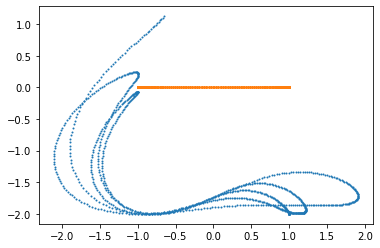

In [13]:
fig, ax = plt.subplots()
step = int(len(R[:, 0]) / 1000)
ax.scatter(r[::step, 0], r[::step, 2], s=1)
ax.scatter(R[::step, 0], R[::step, 2], s=1)